### Skalowanie & Kodowanie & Strojenie hiperparametrów modeli

In [1]:
# Pakiety
import pandas as pd 
import numpy as np

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler,FunctionTransformer

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score

np.random.seed(123) 

# Wczytywanie danych
#data = pd.read_csv('/home/elzbieta/WUM_project1/Feature_Engineering/german_credit_data_dataset.csv')
data = pd.read_csv('german_credit_data_dataset.csv')
data = pd.DataFrame(data)

In [2]:
# Kolumny z danymi numerycznymi
num = data.select_dtypes(include=['float64', 'int']).drop('customer_type', axis = 1).columns

# Kolumny z danymi kategorycznymi
cat = data.select_dtypes(include=['object']).columns.tolist()

### 1. Skalowanie danych numerycznych

In [3]:
scaler = StandardScaler()
scaled = data.copy()
scaled[num] = scaler.fit_transform(data[num])

### 2. Podział na zbiory trenigowe i testowe

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])

### 3. Model

#### 3.1. Random Forest  
Hiperparametry:  

**n_estimators** - ilość drzew składowych (int, domyślnie 100)  
**criterion** - funkcja miary jakości podziału (string, domyślnie gini)  
**max_depth** - maksymalna głębokość drzewa (int, domyślnie None)   
**min_samples_split** - minimalna liczba obserwacji wymagana do podziału węzła wewnętrznego (int/float, domyślnie 2)  
**min_samples_leaf** - minimalna liczba obserwacji wymagana względem liścia (int, domyślnie 1)  
**min_weight_fraction_leaf** - minimalna frakcja wag wymagana względem liścia (domyślnie 0)  
**max_features** - ilość cech branych pod uwagę podczas poszukiwania najlepszego podziału (string). Jeśli “sqrt”, to max_features=sqrt(n_features), jeśli “log2”, to max_features=log2(n_features).  
**max_leaf_nodes** - maksymalna liczba liści (int, domyślnie None)  
**min_impurity_decrease** - węzeł zostanie podzielony, jeśli podział ten spowoduje zmniejszenie miary impurity większe lub równe tej wartości. (float, domyślnie 0)  
**min_impurity_split** - Próg zatrzymania wzrostu drzew. Węzeł rozdzieli się, jeśli jego impurity przekroczy próg, w przeciwnym razie będzie liściem. (float, default 1e-7)  
**bootstrap** - stosowanie bootstrap (bool, domyślnie True)  
**oob_score** - Gdy zestaw treningowy dla bieżącego drzewa jest rysowany przez próbkowanie z wymianą, około jedna trzecia przypadków jest pomijana. Te dane OOB są używane do uzyskania bezstronnego oszacowania błędu klasyfikacji (bool, domyślnie False)  
**oob_score** - liczba powtórzeń instukcji fit, predict, ect.  
**random_state** - kontroluje losowość procedury bootstrap   
**verbose** - int, domyślnie 0 - im wyższa liczba tym więcej informacji uzyskami na temat procedur fit i predict  
**warm_start** - Po ustawieniu wartości True ponownie użyje bieżącego rozwiązania, aby dopasować i dodać więcej estymatorów do zestawu, w przeciwnym razie po prostu zmieni cały nowy las. (bool, domyślnie False)  
**ccp_alpha** - dotyczy przycinania, zostanie wybrane poddrzewo o największym koszcie, który jest mniejszy niż ccp_alpha. Domyślnie 0.0, czyli przycinanie nie jest wykonywane.  
**max_samples** - dotyczy procedury bootstrap (domyślnie None)

In [9]:
def makePipeline(cat_indices, num_indices, classificator, encoder, scaled = False):
    
    if scaled == True:
        pipeline = Pipeline(steps = [
        ('feature_processing', FeatureUnion(transformer_list = [
                ('categorical', FunctionTransformer(lambda data: data[cat_indices])),

                #numeric
                ('numeric', Pipeline(steps = [
                    ('select', FunctionTransformer(lambda data: data[num_indices])),
                    ('scale', StandardScaler())
                            ]))
            ])),
        ('encoder', encoder),
        ('classifier', classificator)
        ]
    )
    else:
        pipeline = Pipeline([
        ('encoder', encoder),
        ('classifier', classificator)
        ])
    return pipeline
        

# Funkcja, która zmierzy nam ilsoc czasu potrzebna na wykonanie danej funkcji

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [22]:
# Model
rf_classifier = RandomForestClassifier()

# Hiperparametry
rf_param_grid = {
    'classifier__n_estimators' : [50, 100, 200],
    'classifier__max_depth' : [None, 4, 8],
    'classifier__min_samples_split' : [1.0, 2, 4],
    'classifier__min_samples_leaf' : [1, 2, 3],
    'classifier__min_weight_fraction_leaf' : [0, 0.2, 0.5],
    'classifier__max_features' : ['sqrt', 'log2', 'auto'],
    'classifier__max_leaf_nodes' : [None, 4, 10],
    'classifier__min_impurity_decrease' : [1e-7, 1e-5, 1e-3],
    'classifier__oob_score' : [True, False],
    'classifier__random_state' : [None, 42],
    'classifier__ccp_alpha' : [0.0, 0.1, 0.2],
    'classifier__max_samples' : [None, 0.1, 0.5, 0.9]    
}

In [38]:
# one-hot-encoding random
rf_ohe_pipeline = makePipeline(cat, num, rf_classifier, ce.OneHotEncoder(), False)

rf_ohe_random_search = RandomizedSearchCV(rf_ohe_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_ohe_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(rf_ohe_random_search.best_score_)
print(rf_ohe_random_search.best_params_)

{'classifier__random_state': None, 'classifier__oob_score': True, 'classifier__n_estimators': 200, 'classifier__min_weight_fraction_leaf': 0, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_impurity_decrease': 1e-07, 'classifier__max_samples': 0.1, 'classifier__max_leaf_nodes': 10, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__ccp_alpha': 0.0}


In [39]:
# one-hot-encoding-scaled random
rf_ohe_scaled_pipeline = makePipeline(cat, num, rf_classifier, ce.OneHotEncoder(), True)

rf_ohe_scaled_random_search = RandomizedSearchCV(rf_ohe_scaled_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_ohe_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(rf_ohe_scaled_random_search.best_score_)
print(rf_ohe_scaled_random_search.best_params_)

{'classifier__random_state': 42, 'classifier__oob_score': False, 'classifier__n_estimators': 200, 'classifier__min_weight_fraction_leaf': 0, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_samples': 0.1, 'classifier__max_leaf_nodes': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 4, 'classifier__ccp_alpha': 0.0}


In [40]:
# target random
rf_target_pipeline = makePipeline(cat, num, rf_classifier, ce.TargetEncoder(), False)

rf_target_random_search = RandomizedSearchCV(rf_target_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_target_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(rf_target_random_search.best_score_)
print(rf_target_random_search.best_params_)

{'classifier__random_state': None, 'classifier__oob_score': True, 'classifier__n_estimators': 200, 'classifier__min_weight_fraction_leaf': 0, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_impurity_decrease': 1e-05, 'classifier__max_samples': 0.9, 'classifier__max_leaf_nodes': None, 'classifier__max_features': 'auto', 'classifier__max_depth': 8, 'classifier__ccp_alpha': 0.0}


In [41]:
# target-scaled random
rf_target_scaled_pipeline = makePipeline(cat, num, rf_classifier, ce.TargetEncoder(), True)

rf_target_scaled_random_search = RandomizedSearchCV(rf_target_scaled_pipeline, param_distributions = rf_param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = -1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
rf_target_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(rf_target_scaled_random_search.best_score_)
print(rf_target_scaled_random_search.best_params_)

{'classifier__random_state': None, 'classifier__oob_score': True, 'classifier__n_estimators': 200, 'classifier__min_weight_fraction_leaf': 0, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 3, 'classifier__min_impurity_decrease': 1e-05, 'classifier__max_samples': 0.9, 'classifier__max_leaf_nodes': None, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__ccp_alpha': 0.0}


#### 3.2. XGBoost

Hiperparametry:  

-**n_estimators** - ilość drzew składowych (int, domyślnie 100)

-**max_depth** - do uzpełnienia

-**min_child_weight** - do uzpełnienia

-**gamma** - do uzpełnieni

-**subsample** - do uzpełnieni

-**colsample_bytree** - do uzpełnieni

-**learning_rate** - do uzpełnieni

In [10]:
# Funkcja, która znajduje optymalną ilosć drzew (n_estimators parameter) uzywając funkcji cv xgboosta dla
# danej wartosci learning_rate i zmienia wartosc n_estimators odpowiednio

def modelfit(alg, dtrain, predictors, cv_folds = 5, early_stopping_rounds = 50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'],
                      nfold=cv_folds, metrics='auc', early_stopping_rounds = early_stopping_rounds)
    alg.set_params(n_estimators = cvresult.shape[0])

In [13]:
# siatka parametrów do strojenia

param_grid = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__min_child_weight': range(1,10,1),
    'classifier__gamma': [i/10.0 for i in range(0,50,5)],
    'classifier__subsample': [i/100.0 for i in range(50,100,5)],
    'classifier__colsample_bytree': [i/100.0 for i in range(50,100,5)],
    'classifier__learning_rate': [0.0001,0.01,0.1,0.2,0.3],
    'classifier__n_estimators': [50,100,150,300,500,600,700,800,1000]
    }

# domyslny classifier

xgb_classifier = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=4)


In [42]:
# one-hot-encoding random
xgb_ohe_pipeline = makePipeline(cat, num, xgb_classifier, ce.OneHotEncoder(), False)

ohe_random_search = RandomizedSearchCV(xgb_ohe_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
ohe_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(ohe_random_search.best_score_)
print(ohe_random_search.best_params_)

{'classifier__subsample': 0.6, 'classifier__n_estimators': 700, 'classifier__min_child_weight': 3, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.01, 'classifier__gamma': 1.0, 'classifier__colsample_bytree': 0.75}


In [43]:
# one-hot-encoding-scaled random
xgb_ohe_scaled_pipeline = makePipeline(cat, num, xgb_classifier, ce.OneHotEncoder(), True)

ohe_scaled_random_search = RandomizedSearchCV(xgb_ohe_scaled_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
ohe_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(ohe_scaled_random_search.best_score_)
print(ohe_scaled_random_search.best_params_)

{'classifier__subsample': 0.6, 'classifier__n_estimators': 700, 'classifier__min_child_weight': 3, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.01, 'classifier__gamma': 1.0, 'classifier__colsample_bytree': 0.75}


In [44]:
# target random
xgb_target_pipeline = makePipeline(cat, num, xgb_classifier, ce.TargetEncoder(), False)

target_random_search = RandomizedSearchCV(xgb_target_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
target_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(target_random_search.best_score_)
print(target_random_search.best_params_)

{'classifier__subsample': 0.6, 'classifier__n_estimators': 50, 'classifier__min_child_weight': 3, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 4.5, 'classifier__colsample_bytree': 0.9}


In [45]:
# target-scaled random
xgb_target_scaled_pipeline = makePipeline(cat, num, xgb_classifier, ce.TargetEncoder(), True)

target_scaled_random_search = RandomizedSearchCV(xgb_target_scaled_pipeline, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
target_scaled_random_search.fit(X_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(target_scaled_random_search.best_score_)
print(target_scaled_random_search.best_params_)

{'classifier__subsample': 0.95, 'classifier__n_estimators': 600, 'classifier__min_child_weight': 4, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.2, 'classifier__gamma': 2.0, 'classifier__colsample_bytree': 0.75}


### 4. Ewaluacja modeli

In [26]:
def evaluateModel(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_true = Y_test
    print("Accuracy: " + str(accuracy_score(y_true, y_pred, normalize=False)))
    print("Precision: " + str(precision_score(y_true, y_pred, average='macro')))
    print("Recall: " + str(recall_score(y_true, y_pred)))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=2)
    print("AUC: " + str(metrics.auc(fpr, tpr)))
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
def returnAUC(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_true = Y_test
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=2)
    return metrics.auc(fpr, tpr)

In [30]:
rf_ohe = rf_ohe_random_search.best_estimator_

rf_ohe_scaled = rf_ohe_scaled_random_search.best_estimator_

rf_target = rf_target_random_search.best_estimator_

rf_target_scaled = rf_target_scaled_random_search.best_estimator_

In [28]:
xgb_ohe = ohe_random_search.best_estimator_

xgb_ohe_scaled = ohe_scaled_random_search.best_estimator_

xgb_target = target_random_search.best_estimator_

xgb_target_scaled = target_scaled_random_search.best_estimator_

In [46]:
model = ["rf_ohe","rf_ohe_scaled","rf_target","rf_target_scaled",
        "xgb_ohe", "xgb_ohe_scaled", "xgb_target", "xgb_target_scaled"]
auc_values = []

for i in model:
    current_model = eval(i)
    auc_values.append(returnAUC(current_model, X_train, Y_train, X_test, Y_test))


pd.DataFrame({
    "Model" : model,
    "AUC": auc_values
})

,Model,AUC
0,rf_ohe,0.819251
1,rf_ohe_scaled,0.805096
2,rf_target,0.815621
3,rf_target_scaled,0.823969
4,xgb_ohe,0.812427
5,xgb_ohe_scaled,0.812427
6,xgb_target,0.816057
7,xgb_target_scaled,0.799724


Accuracy: 185
Precision: 0.7268642782121602
Recall: 0.9285714285714286
AUC: 0.8281068524970964


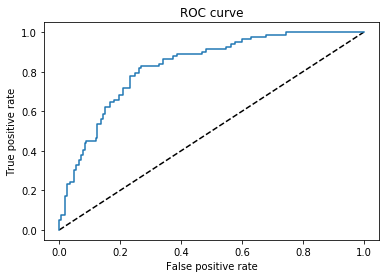

In [47]:
evaluateModel(rf_target, X_train, Y_train, X_test, Y_test)

Accuracy: 193
Precision: 0.755944055944056
Recall: 0.9107142857142857
AUC: 0.8160569105691057


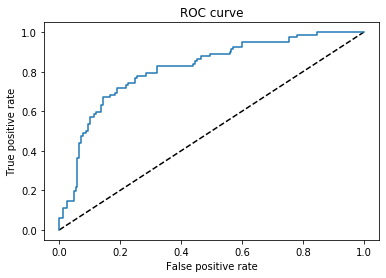

In [48]:
evaluateModel(xgb_target, X_train, Y_train, X_test, Y_test)

Accuracy: 185
Precision: 0.7172728225552877
Recall: 0.9107142857142857
AUC: 0.8304297328687572


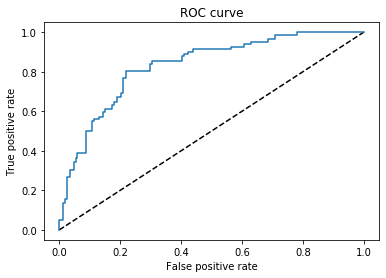

In [49]:
evaluateModel(rf_target_scaled, X_train, Y_train, X_test, Y_test)

Accuracy: 188
Precision: 0.7228070175438597
Recall: 0.8809523809523809
AUC: 0.7997241579558653


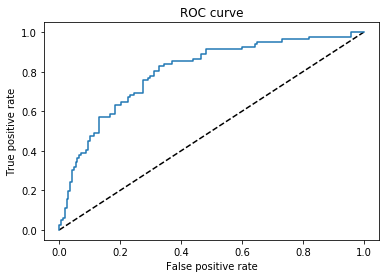

In [50]:
evaluateModel(xgb_target_scaled, X_train, Y_train, X_test, Y_test)

In [52]:
xgb_target_scaled.steps[2]

('classifier',
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.75, gamma=2.0, gpu_id=-1,
               importance_type='gain', interaction_constraints=None,
               learning_rate=0.2, max_delta_step=0, max_depth=2,
               min_child_weight=4, missing=nan, monotone_constraints=None,
               n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.95,
               tree_method=None, validate_parameters=False, verbosity=None))

In [53]:
rf_target_scaled.steps[2]

('classifier',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='log2',
                        max_leaf_nodes=None, max_samples=0.9,
                        min_impurity_decrease=1e-05, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=2,
                        min_weight_fraction_leaf=0, n_estimators=200,
                        n_jobs=None, oob_score=True, random_state=None,
                        verbose=0, warm_start=False))

In [56]:
rf_target.steps[1]

('classifier',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=8, max_features='auto',
                        max_leaf_nodes=None, max_samples=0.9,
                        min_impurity_decrease=1e-05, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=2,
                        min_weight_fraction_leaf=0, n_estimators=200,
                        n_jobs=None, oob_score=True, random_state=None,
                        verbose=0, warm_start=False))

In [57]:
xgb_target.steps[1]

('classifier',
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=4.5, gpu_id=-1,
               importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=0, max_depth=4,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               n_estimators=50, n_jobs=4, nthread=4, num_parallel_tree=1,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.6,
               tree_method=None, validate_parameters=False, verbosity=None))